# "Linear Regression: A non-authoritative guide"
> "A stupid person teaching you linear regression"
- toc: true
- badges: true
- comments: true
- categories: [machine-learning]

This is a rather amateur attempt at explanation of Linear Regression. One of the first algorithms taught to students starting Machine Learning. If this is for an assignment, I urge you to not copy this any of this code. This blog post is a modified version of one of my first homework assignments from my Machine Learning class.

## Dependencies
1. Programming Knowledge to understand the walkthrough (Python in this case)
    - [NumPy](https://numpy.org) for linear algebra computations
    - Pandas (Optional) - To import read our csv. You could use other things such as Excel files.
    - matplotlib - To graph
    - **Refer to [CS 231's introduction to Python](https://cs231n.github.io/python-numpy-tutorial/)** for an introduction/review to Python, NumPy, and scikit
2. A dataset to test upon. In this tutorial I shall be using the [carbig dataset from Matlab](https://www.mathworks.com/help/stats/sample-data-sets.html).
3. High school math equivalent knowledge: For this tutorial I expect you to understand basic algebra, graphs, maybe a bit of linear algebra. I'll still try to make this as much as a self contained tutorial as I can

I am not going to explain every single function I use in this tutorial,I highly encourage people to look up the reference guides for NumPy and alike

## Initial Setup
Since I am writing this Notebook in Kaggle, the code below is some setup boiler plate, go through the code to get an idea of what's happening in there.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # To graph

## About the dataset
The carbig dataset is a relatively simple dataset, with two columns: Weight and Horsepower. Our task in this case would be a simple "Given this weight, predict the Horsepower". In this dataset, we notice that there are a few missing datapoints for the Horsepower column, so we need to deal with that too.

In [2]:
# Loading up the dataset
carbig_data = pd.read_csv("/kaggle/input/proj1-dataset/proj1Dataset.csv")

# Assign Data to variables
X = carbig_data['Weight']
carbig_data['Horsepower'] = carbig_data['Horsepower'].fillna(carbig_data['Horsepower'].median()) #Replacing missing values with the median
t_target = carbig_data['Horsepower']

So in the code above, we loaded up our data, and assigned the columns to 2 variables: X and t. We also dealt with the missing values in the code above by replacing them with the median of the rest of the dataset. There's quite a few different methods of dealing with this, this is just one of them.

> NOTE: For debugging, I suggest you to familiarize yourself with the reshape function within numpy: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html . Checking for the shapes of these matrices is one way to tell if you're on the right track, and might explain the steps next.

### More preprocessing of the data:

In [3]:
# Reshape and prep X, and X_norm
X = np.reshape(X.values, (-1, 1))
X_norm = np.empty(X.shape)
X_norm = X/X.max() # What we're doing is Normalizing the data
t_target = np.reshape(t_target.values, (-1, 1))

Before implementing the Linear Regression Algorithms, we still need to do one final thing to our X variable. And that is to append a column of ones, so it transforms into something called a design matrix. We also are normalizing our data, to understand why we normalize our data, the fast version is that it makes computations easier and fast for the computer. To get a more detailed explanation here is a link to an actual paper that *I have totally read /s* http://arxiv-export-lb.library.cornell.edu/pdf/1503.06462

In [4]:
# Add one as the design matrices to both of them
X = np.hstack((X, np.ones(X.shape)))
X_norm = np.hstack((X_norm, np.ones(X_norm.shape))) # This is our normalized X

## Implementing the Linear Regression Algorithm: Closed Form Solution

![Equation for Closed Form Solution of Linear Regression](https://imgur.com/a/71YJgJS) (Expecting this image to show up, if it doesn't go ahead and click on the link to see the equation). Keep in mind that I won't use the same convention as the one showed in the image. I shall be calling "beta" as "weight", and y as target (or t in the code)

So after seeing the equation, let's start implementing it!

In [5]:
def closed_form_solution(x, t):
    """Linear Regression using the closed form solution"""
    weight = (np.linalg.pinv(x) @ t).T # The weight equation implemented in one swoop, notice we take the transpose of the whole thing
    d_closed = np.linspace(1500, 5500, 3500) # For graphing purposes, to have all the x values in order
    #print(weight.T) # For debugging purposes
    prediction_closed = weight.T [0][0]*d_closed + weight.T[1][0] # After calculating the weight, we find our prediction
    
    # Actually graphing the prediction
    plt.title("Closed Form Solution - Linear Regression")
    plt.scatter(X[:,0], t, label="actual data")
    plt.xlabel('Weight')
    plt.ylabel('Horsepower')
    plt.plot(d_closed, prediction_closed, color = "red", label="Closed Form Solution")
    plt.legend()
    plt.figure()


Let's call this silly function and see what happens!

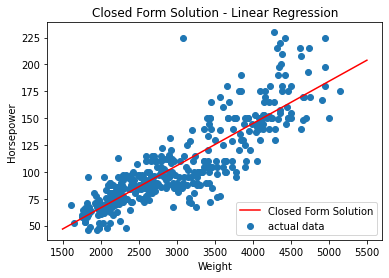

<Figure size 432x288 with 0 Axes>

In [6]:
closed_form_solution(X, t_target)

That actually looks like a pretty great. But notice that this was everything done in one **amazing** swoop. This rarely happens in any actual machine learning, since most of the time it's an iterative process, and that's what we're going to talk about next - Linear Regression using Gradient Descent. Keep in mind Gradient Descent is a much more general algorithm, and this is one type of G.D. being used in one particular way.

Bu...tt before we do, let's talk about the concept of Cost Function

### Loss/Cost Function: What is it?
For now I am going to be using Loss and Cost as interchangable terms, even though they're technically not, just bear with me for the time being.

A loss/cost function is basically a way to compute how wrong (or right, if you're that kind of person) your prediction was from the true value. Loss functions are absolutely essential for Machine Learning Algorithms, and in the upcoming Gradient Descent Solution, you shall see why

## Gradient Descent Solution to Linear Regression

Now I know I tried to say that I will try to keep this as contained of a blog post I could, but I feel like Gradient Descent is one of those topics which could really help some visualization rather than a boring blog post. So I'll link you to a [classic old yet relevant video by Andrew Ng](https://youtu.be/F6GSRDoB-Cg). Now this is just one video, you can find numerous others. It's not that it's my favorite, but Ng does an amazing job behind explaining the intution of Gradient Descent. Come back here for the code.

--- I'm serious, I am not explaining the theory here. Go! ---

Hopefully now you understand the theory behind gradient descent. So now let's implement it from scratch.

In [7]:
def gradient_descent(iterations, rho, weight, x, t): #rho here refers to the learning rate, told ya pay attention!
    """
    Gradient Descent Solution for the weight for Linear Regression
    """
    for i in range(iterations):
        gradient = ((2* weight.T @ x.T@ x ) - (2* t.T @ x)).T
        weight = weight - (rho * gradient)
        #print("Iteration {} 's loss: {}".format(i, (np.square(np.linalg.norm(t - x @ weight))))) #uncomment this to see loss updating
    d_grad = np.linspace(1500, 5500, 3500)
    weight[0][0] = weight[0][0] / X.max()
    # print(weight) # debugging purposes
    prediction_grad = weight.T [0][0]*d_grad + weight.T[0][1]
    plt.title("Gradient Descent Solution to  Linear Regression")
    plt.scatter(X[:,0], t, label="actual data")
    plt.xlabel('Weight')
    plt.ylabel('Horsepower')
    plt.plot(d_grad, prediction_grad, color = "green", label="Gradient Descent Solution")
    plt.legend()
    plt.show()

> Here we are commenting out the loss updates but you can see by uncommenting that line!

The for loop in the code above is where we're updating the weight. Ideally we want a stop condition, aside from just going through however many iterations we call, so it should be something like when the difference between the result of the current iteration, and past iteration is too small? This part will be left as an exercise to the reader ;)

Now we'll need some assumptions. By which I mean set some hyperparameters (parameters you set before learning)

In [8]:
# Initial Assumptions made
init_weight = np.array([0, 0])
init_weight = np.reshape(init_weight, (-1, 1))
max_iterations = 1000 #(epochs)
rho_learning_rate = 0.001

> These were some of my parameters which worked well for me, but I got here by tuning the numbers and seeing how it affects the performance of the function. I urge y'all to change these numbers and see how it changes the final performance.

Let's call the function!

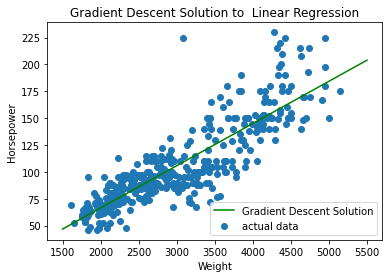

In [9]:
gradient_descent(max_iterations, rho_learning_rate, init_weight, X_norm, t_target)

> Notice how we're using the Normalized X variable here, but we didn't do this in the Closed Form solution. Why?

There's more to Linear Regression, but this should be enough to get ya started don't ya think?

Alvida?
Ciao?
Au Revoir?


bye